# <b> <font color='#A20025'> 📚 Chapter 4: Solubility Deep Dive with Linear Models

*This notebook contains the code examples in chapter 4. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH04_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

You'll learn how to:
- Acquire and preprocess molecular solubility data
- Calculate and select molecular descriptors relevant to solubility
- Build and evaluate linear regression models
- Apply various types of linear models including Ridge, RANSAC, and Support Vector Regression
- Evaluate models and understand their applicability domains
- Analyze model performance using bias-variance tradeoff concepts

## <b> <font color='#A20025'> ⚙️ Environment Setup 

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
CHAPTER = "ch04"
os.makedirs(f"artifacts/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}", exist_ok=True)
os.makedirs(f"figures/{CHAPTER}", exist_ok=True)
!wget artifacts and data
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch04/solubility_aqsoldb_test.pkl.gz" -O "artifacts/ch04/solubility_aqsoldb_test.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch04/solubility_aqsoldb_train.pkl.gz" -O "artifacts/ch04/solubility_aqsoldb_train.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch04/solubility_aqsoldb_valid.pkl.gz" -O "artifacts/ch04/solubility_aqsoldb_valid.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch04/delaney_solubility.txt" -O "data/ch04/delaney_solubility.txt"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch04/solubility_aqsoldb.tab" -O "data/ch04/solubility_aqsoldb.tab"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/ml4dd2025.yml" -O "env.yml"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/utils.py" -O "utils.py"

In [ ]:
# Colab users only
!pip install -q condacolab
import condacolab
condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab users only
# Verify condalab installation
import condacolab
condacolab.check()

In [ ]:
# Colab users only
# We can only use the base environment in `condacolab`, so we will update it with the `env.yml` file we downloaded earlier.
!mamba env update -n base -f env.yml

### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [35]:
# Core packages
import os
from pathlib import Path

# Core data science packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.auto import tqdm

# Machine learning packages
from sklearn.linear_model import (
    LinearRegression, Ridge, RidgeCV, Lasso, 
    SGDRegressor, RANSACRegressor
)
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_validate,
    learning_curve, validation_curve, StratifiedKFold,
    LearningCurveDisplay, ValidationCurveDisplay,
    RandomizedSearchCV
)
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    calinski_harabasz_score, silhouette_score, davies_bouldin_score
)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

# Chemical informatics packages
from rdkit import Chem
from rdkit.Chem import (
    Descriptors, Draw, Crippen, GraphDescriptors, Lipinski, 
    rdMolDescriptors, MolFromSmiles, MolFromSmarts
)

# Utility functions
from utils import (
    save_molecular_dataframe,
    load_molecular_dataframe,
    list_saved_dataframes,
)

### <b> <font color='#A20025'> Configure Settings

In [2]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [4]:
# Matplotlib and Seaborn setup for consistent visualizations
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    colors = ["#A20025", "#6C8EBF"]  # Define a color palette
    sns.set_palette(sns.color_palette(colors))
    plt.rcParams['figure.dpi'] = 100 # Adjust for better resolution inline
    plt.rcParams['savefig.dpi'] = 600 # High resolution for saved figures
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 14   
    plt.rcParams['xtick.labelsize'] = 12   
    plt.rcParams['ytick.labelsize'] = 12    

setup_visualization_style()
%matplotlib inline

In [5]:
# RDKit drawing setup
def setup_rdkit_drawing():
    """Configure RDKit drawing settings for consistent molecular visualizations"""
    d2d = Draw.MolDraw2DSVG(-1, -1)
    dopts = d2d.drawOptions()
    dopts.useBWAtomPalette()
    dopts.setHighlightColour((.635, .0, .145, .4))
    dopts.baseFontSize = 1.0
    dopts.additionalAtomLabelPadding = 0.15
    dopts.dotsPerAngstrom = 100
    return dopts

rdkit_drawing_options = setup_rdkit_drawing()

## <b> <font color='#A20025'> 1️⃣ Solubility with Linear Regression

Aqueous solubility is a fundamental property that affects drug absorption, bioavailability, and formulation. It is typically measured in mol/L and often reported as the logarithm of solubility (logS).
 
In this section, we'll:
1. Load a dataset of compounds with measured solubility values
2. Explore the dataset to understand the distribution of solubility values
3. Build a simple linear regression model to predict solubility

### <b> <font color='#A20025'> Load the Data

We'll use the AqSolDB dataset from the Therapeutics Data Commons (TDC), which contains experimental solubility measurements for drug-like compounds.

**<b> Installation Note </b>**

To avoid issues with installing TDC (recently noted by some readers), I've provided the train, validation, and test files in `artifacts/ch04/`. If the files exist in `artifacts/ch04/`, then the `load_solubility_data` function will load those files instead of needing to import and download them from TDC. We recommend checking if the files exist and, if they don't, you can download them at the same location in this repository on GitHub (the `wget` commands at the beginning of the notebook can be used to do this as well).

In [8]:
def load_solubility_data(dataset_name="Solubility_AqSolDB", split_method="scaffold"):
    """
    Load the solubility dataset and split it.
    
    Parameters:
        dataset_name (str): Name of the dataset in TDC
        split_method (str): Method for splitting the data
        
    Returns:
        tuple: (train_df, valid_df, test_df) DataFrames with data splits
    """
    # Define paths for cached data
    cache_paths = {
        'train': f'artifacts/ch04/{dataset_name.lower()}_train.pkl.gz',
        'valid': f'artifacts/ch04/{dataset_name.lower()}_valid.pkl.gz',
        'test': f'artifacts/ch04/{dataset_name.lower()}_test.pkl.gz'
    }
    
    # Check if cached data exists
    if all(os.path.exists(path) for path in cache_paths.values()):
        print(f"Loading {dataset_name} dataset from cached files...")
        train_df = load_molecular_dataframe(f"{dataset_name.lower()}_train.pkl.gz", chapter="ch04")
        valid_df = load_molecular_dataframe(f"{dataset_name.lower()}_valid.pkl.gz", chapter="ch04")
        test_df = load_molecular_dataframe(f"{dataset_name.lower()}_test.pkl.gz", chapter="ch04")
        
        print(f"Loaded {dataset_name} cached dataset")
        print(f"Training set: {len(train_df)} compounds")
        print(f"Validation set: {len(valid_df)} compounds")
        print(f"Test set: {len(test_df)} compounds")
    else:
        # If cached data doesn't exist, load from TDC
        print(f"Cached data not found. Loading {dataset_name} dataset from TDC...")
        from tdc.single_pred import ADME
        
        data = ADME(name=dataset_name)
        print(f"Loaded dataset with {len(data)} total compounds")
        
        # Get the data splits
        print(f"Splitting data using {split_method} method...")
        splits = data.get_split(method=split_method)
        
        train_df, valid_df, test_df = splits['train'], splits['valid'], splits['test']
        print(f"Loaded {dataset_name} dataset")
        print(f"Training set: {len(train_df)} compounds")
        print(f"Validation set: {len(valid_df)} compounds")
        print(f"Test set: {len(test_df)} compounds")
        
        # Create directory if it doesn't exist
        Path('artifacts/ch04').mkdir(parents=True, exist_ok=True)
            
        # Optional: Save the loaded data for future use
        # Uncomment if you want to cache the data after loading from TDC
        save_molecular_dataframe(train_df, f"{dataset_name.lower()}_train.pkl.gz", chapter="ch04")
        save_molecular_dataframe(valid_df, f"{dataset_name.lower()}_valid.pkl.gz", chapter="ch04")
        save_molecular_dataframe(test_df, f"{dataset_name.lower()}_test.pkl.gz", chapter="ch04")
        
    return train_df, valid_df, test_df

In [13]:
# Load the solubility dataset
train_df, valid_df, test_df = load_solubility_data()

# Display basic information
logger.info("Dataset information:")
display(train_df.info())

# Display the first few rows
logger.info("First few rows:")
display(train_df.head())

2025-03-29 17:33:53,018 - INFO - Dataset information:


Loading Solubility_AqSolDB dataset from cached files...
Loading molecular dataframe from artifacts/ch04/solubility_aqsoldb_train.pkl.gz...
Successfully loaded dataframe with 6987 rows and 3 columns
Loading time: 0.01 seconds
Loading molecular dataframe from artifacts/ch04/solubility_aqsoldb_valid.pkl.gz...
Successfully loaded dataframe with 998 rows and 3 columns
Loading time: 0.00 seconds
Loading molecular dataframe from artifacts/ch04/solubility_aqsoldb_test.pkl.gz...
Successfully loaded dataframe with 1997 rows and 3 columns
Loading time: 0.00 seconds
Loaded Solubility_AqSolDB cached dataset
Training set: 6987 compounds
Validation set: 998 compounds
Test set: 1997 compounds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6987 entries, 0 to 6986
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  6987 non-null   object 
 1   Drug     6987 non-null   object 
 2   Y        6987 non-null   float64
dtypes: float64(1)

None

2025-03-29 17:33:53,040 - INFO - First few rows:


,Drug_ID,Drug,Y
0,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
1,vinyltoluene,C=Cc1cccc(C)c1,-3.123150
2,4-(dimethylamino)benzaldehyde,CN(C)c1ccc(C=O)cc1,-2.282769
3,2-methyl-1-phenylpropan-2-yl acetate,CC(=O)OC(C)(C)Cc1ccccc1,-2.394650
4,5-methoxy-1-[4-(trifluoromethyl)phenyl]pentan-...,COCCCCC(=O)c1ccc(C(F)(F)F)cc1,-3.544060


### <b> <font color='#A20025'> Target Variable Distribution

Let's examine the distribution of solubility values in our dataset to better understand the prediction task.

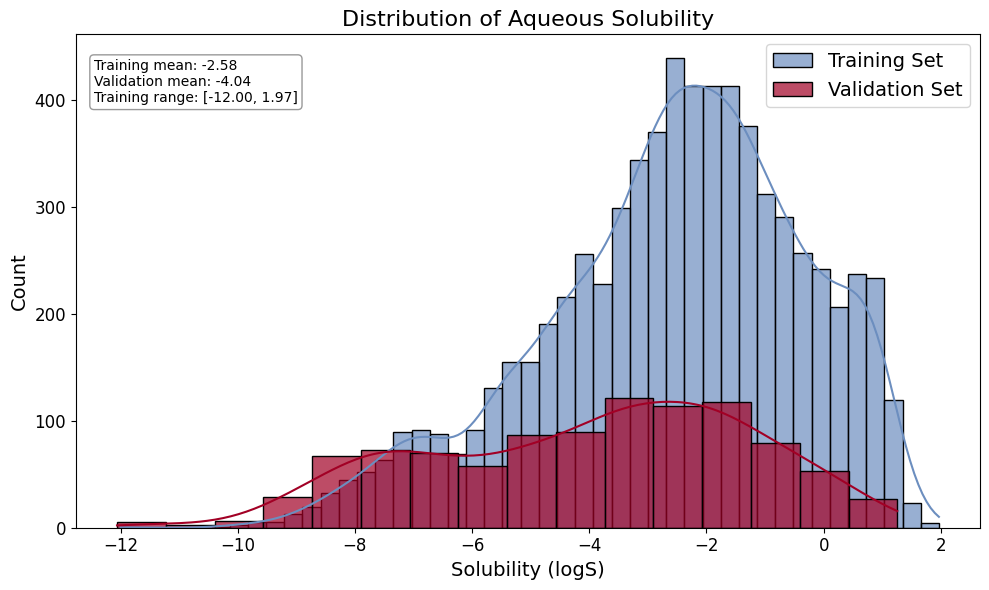

In [10]:
def visualize_target_distribution(train_df, valid_df, target_col="Y"):
    """
    Visualize the distribution of the target variable.
    
    Parameters:
        train_df (pandas.DataFrame): Training data
        valid_df (pandas.DataFrame): Validation data
        target_col (str): Column name for the target variable
        
    Returns:
        matplotlib.figure.Figure: Figure with visualization
    """
    plt.figure(figsize=(10, 6))
    
    # Plot training data distribution
    sns.histplot(
        train_df[target_col], 
        kde=True, 
        label='Training Set',
        alpha=0.7,
        color="#6C8EBF"
    )
    
    # Plot validation data distribution (to check for distribution shift)
    sns.histplot(
        valid_df[target_col], 
        kde=True, 
        label='Validation Set',
        alpha=0.7,
        color="#A20025"
    )
    
    # Add labels and title
    plt.xlabel('Solubility (logS)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of Aqueous Solubility', fontsize=16)
    
    # Add annotations about the data
    plt.annotate(
        f"Training mean: {train_df[target_col].mean():.2f}\n"
        f"Validation mean: {valid_df[target_col].mean():.2f}\n"
        f"Training range: [{train_df[target_col].min():.2f}, {train_df[target_col].max():.2f}]",
        xy=(0.02, 0.95),
        xycoords='axes fraction',
        ha='left',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    plt.legend()
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('figures/ch04/solubility_dists.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch04/solubility_dists.pdf', bbox_inches='tight', dpi=600)
    
    return plt.gcf()

# Visualize the target distribution
if train_df is not None and valid_df is not None:
    solubility_dist_fig = visualize_target_distribution(train_df, valid_df)

### <b> <font color='#A20025'> Adding Molecule Objects and Checking for Multiple Fragments

We'll start by adding RDKit molecule objects to our dataframes.

In [ ]:
def add_molecule_objects(df, smiles_col="Drug", mol_col="Molecule"):
    """
    Add RDKit molecule objects to a dataframe.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing SMILES strings
        smiles_col (str): Column name with SMILES strings
        mol_col (str): Column name to store molecule objects
        
    Returns:
        pandas.DataFrame: DataFrame with molecule objects
    """
    from rdkit.Chem import PandasTools
    
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Add molecule column
    logger.info(f"Converting SMILES to RDKit molecules...")
    PandasTools.AddMoleculeColumnToFrame(df_copy, smiles_col, mol_col)
    
    # Count valid molecules
    valid_count = df_copy[mol_col].notnull().sum()
    invalid_count = df_copy[mol_col].isnull().sum()
    
    logger.info(f"Valid molecules: {valid_count}")
    logger.info(f"Invalid molecules: {invalid_count}")
    
    return df_copy

# Add molecule objects
train_df = add_molecule_objects(train_df)

# Do the same for validation set
valid_df = add_molecule_objects(valid_df)

2025-03-29 17:35:26,901 - INFO - Converting SMILES to RDKit molecules...
[17:35:26] WARNING: not removing hydrogen atom without neighbors
[17:35:26] WARNING: not removing hydrogen atom without neighbors
[17:35:26] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNING: not removing hydrogen atom without neighbors
[17:35:27] WARNIN

Let's visualize molecules with extremely high and low solubility to get a better understanding of structural characteristics that might influence solubility.


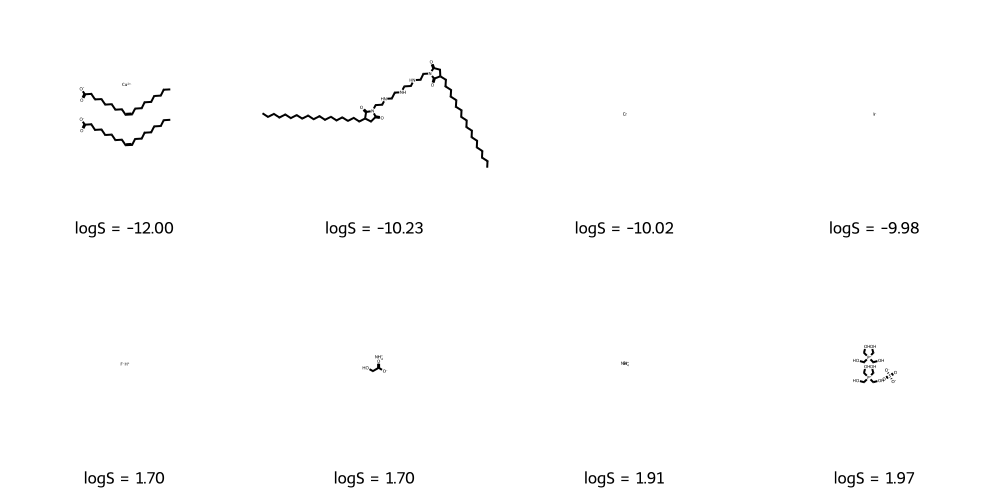

In [16]:
def visualize_solubility_extremes(df, target_col="Y", mol_col="Molecule", n=4):
    """
    Visualize molecules with extremely high and low solubility.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing molecules and solubility values
        target_col (str): Column name for solubility values
        mol_col (str): Column name for molecule objects
        n (int): Number of molecules to show from each extreme
        
    Returns:
        rdkit.Chem.Draw._MolsToGridImage: Grid image of molecules
    """
    # Sort by solubility
    df_sorted = df.sort_values(target_col)
    
    # Get low and high solubility molecules
    low_solubility = df_sorted.head(n)
    high_solubility = df_sorted.tail(n)
    
    # Combine into one dataframe
    extremes = pd.concat([low_solubility, high_solubility])
    
    # Create legends with solubility values
    legends = [f"logS = {x:.2f}" for x in extremes[target_col]]
    
    # Create the visualization
    img = Draw.MolsToGridImage(
        extremes[mol_col].tolist(), 
        molsPerRow=n, 
        subImgSize=(250, 250),
        legends=legends, 
        useSVG=True, 
        drawOptions=rdkit_drawing_options
    )
    
    # Save the image
    with open("figures/ch04/solubility_extremes.svg", "w") as f:
        f.write(img.data)
    
    return img

# Visualize molecules with extreme solubility
extremes_img = visualize_solubility_extremes(train_df)
display(extremes_img)

We see several issues at the extremes, including instances in the dataset that are composed of multiple molecule fragments. Let's check further for molecules with multiple fragments, which could affect our analysis.

In [17]:
def check_molecule_fragments(df, mol_col="Molecule"):
    """
    Check for molecules with multiple fragments.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing molecule objects
        mol_col (str): Column name with molecule objects
        
    Returns:
        pandas.DataFrame: DataFrame with fragment count column added
    """
    # Create a copy
    df_copy = df.copy()
    
    # Count fragments for each molecule
    logger.info(f"Counting fragments for each molecule...")
    df_copy['fragment_count'] = df_copy[mol_col].apply(
        lambda x: len(Chem.GetMolFrags(x)) if x is not None else np.nan
    )
    
    # Count molecules with different fragment counts
    fragment_counts = df_copy['fragment_count'].value_counts()
    logger.info(f"Fragment count distribution:\n{fragment_counts}")
    
    # Identify molecules with multiple fragments
    multi_fragment = df_copy[df_copy['fragment_count'] > 1]
    logger.info(f"Found {len(multi_fragment)} molecules with multiple fragments")
    
    return df_copy

# Check fragments
train_df = check_molecule_fragments(train_df)

# Do the same for validation set
valid_df = check_molecule_fragments(valid_df)

2025-03-29 17:40:24,160 - INFO - Counting fragments for each molecule...
2025-03-29 17:40:24,236 - INFO - Fragment count distribution:
fragment_count
1     6139
2      393
3      255
4       67
5       65
6       17
7       16
9       11
10       5
13       4
8        4
17       2
11       2
14       2
32       1
21       1
18       1
37       1
12       1
Name: count, dtype: int64
2025-03-29 17:40:24,239 - INFO - Found 848 molecules with multiple fragments
2025-03-29 17:40:24,242 - INFO - Counting fragments for each molecule...
2025-03-29 17:40:24,258 - INFO - Fragment count distribution:
fragment_count
1    921
3     29
2     16
4     13
5     12
6      3
7      3
8      1
Name: count, dtype: int64
2025-03-29 17:40:24,260 - INFO - Found 77 molecules with multiple fragments


We visualize some of the extremes to see what these entries are that have large numbers of fragments:

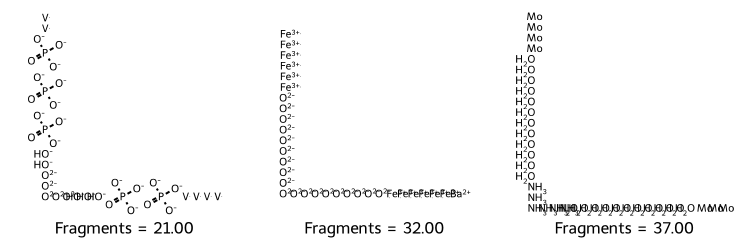

In [ ]:
extremes = train_df.sort_values("fragment_count")[-3:]
legend_text = [
    f"Fragments = {x.fragment_count:.2f}" for x in extremes.itertuples()
]
img = Draw.MolsToGridImage(
    extremes.Molecule, molsPerRow=3, subImgSize=(250, 250), legends=legend_text, useSVG=True, drawOptions=rdkit_drawing_options,
)
with open("figures/ch04/fragment_extremes.svg", "w") as f:
  f.write(img.data)
img

For this chapter, we'll just keep those instances with a fragment count equal to 1.

In [20]:
# Filter out molecules with multiple fragments or invalid molecules
train_df_filtered = train_df[(train_df['fragment_count'] == 1) & (train_df['Molecule'].notnull())]
valid_df_filtered = valid_df[(valid_df['fragment_count'] == 1) & (valid_df['Molecule'].notnull())]

logger.info(f"After filtering, training set has {len(train_df_filtered)} molecules")
logger.info(f"After filtering, validation set has {len(valid_df_filtered)} molecules")

# Update our dataframes
train_df = train_df_filtered.copy()
valid_df = valid_df_filtered.copy()

2025-03-29 17:41:54,193 - INFO - After filtering, training set has 6139 molecules
2025-03-29 17:41:54,194 - INFO - After filtering, validation set has 921 molecules


### <b> <font color='#A20025'> Feature Computation & Correlation

Now, let's calculate molecular descriptors that may be useful for predicting solubility. These descriptors capture various physical and chemical properties of molecules.

In [21]:
def calculate_molecular_descriptors(df, mol_col="Molecule"):
    """
    Calculate molecular descriptors for a dataset.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing molecule objects
        mol_col (str): Column name with molecule objects
        
    Returns:
        pandas.DataFrame: DataFrame with descriptors added
    """
    # Define the descriptors to calculate
    descriptors = {
        'Molecular Weight': Descriptors.MolWt,
        'Number of H-Bond Donors': Descriptors.NumHDonors,
        'TPSA': Descriptors.TPSA,
        'logP': Crippen.MolLogP,
        'Molar Refractivity': Crippen.MolMR,
        'Number of Rotatable Bonds': Lipinski.NumRotatableBonds,
        'Number of Rings': rdMolDescriptors.CalcNumRings,
        'LabuteASA': rdMolDescriptors.CalcLabuteASA,
        'BalabanJ': GraphDescriptors.BalabanJ,
        'BertzCT': GraphDescriptors.BertzCT,
    }
    
    # Add a custom descriptor for aromaticity
    def AromaticProportion(mol):
        """Calculate the proportion of aromatic atoms in a molecule"""
        if mol is None:
            return np.nan
        
        aromatic_atoms = mol.GetSubstructMatches(MolFromSmarts("a"))
        return len(aromatic_atoms) / mol.GetNumAtoms()
    
    descriptors['Aromatic Proportion'] = AromaticProportion
    
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Calculate each descriptor
    logger.info("Calculating molecular descriptors...")
    for desc_name, desc_func in tqdm(descriptors.items()):
        df_copy[desc_name] = df_copy[mol_col].apply(
            lambda x: desc_func(x) if x is not None else np.nan
        )
    
    # Check for missing values
    missing_count = df_copy[list(descriptors.keys())].isna().sum()
    if missing_count.sum() > 0:
        logger.warning(f"Missing values in descriptors:\n{missing_count[missing_count > 0]}")
        
        # Drop rows with missing descriptor values
        df_filtered = df_copy.dropna(subset=list(descriptors.keys()))
        logger.info(f"Dropped {len(df_copy) - len(df_filtered)} rows with missing descriptor values")
        df_copy = df_filtered
    
    return df_copy

# Calculate descriptors for our datasets
train_df = calculate_molecular_descriptors(train_df)
valid_df = calculate_molecular_descriptors(valid_df)

# Display summary statistics
logger.info("Descriptor summary statistics:")
display(train_df.describe())


2025-03-29 17:43:31,083 - INFO - Calculating molecular descriptors...


  0%|          | 0/11 [00:00<?, ?it/s]

2025-03-29 17:43:43,664 - INFO - Calculating molecular descriptors...


  0%|          | 0/11 [00:00<?, ?it/s]

2025-03-29 17:43:46,193 - INFO - Descriptor summary statistics:


,Y,fragment_count,Molecular Weight,Number of H-Bond Donors,TPSA,logP,Molar Refractivity,Number of Rotatable Bonds,Number of Rings,LabuteASA,BalabanJ,BertzCT,Aromatic Proportion
count,6139.000000,6139.0,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000
mean,-2.687823,1.0,231.519567,1.037465,52.514387,2.221913,60.059111,4.188793,1.137645,93.835955,2.838501,361.566059,0.274302
std,2.177925,0.0,129.110402,1.302389,40.799635,2.395077,35.624349,5.183913,1.399430,53.060495,0.783718,344.678348,0.282455
min,-10.234717,1.0,9.012000,0.000000,0.000000,-17.406400,0.000000,0.000000,0.000000,7.504228,0.000000,0.000000,0.000000
25%,-3.970000,1.0,148.203500,0.000000,25.780000,0.866500,38.219800,1.000000,0.000000,60.327033,2.324238,132.937410,0.000000
50%,-2.446100,1.0,206.245000,1.000000,46.330000,1.947500,52.294300,3.000000,1.000000,82.504603,2.847379,280.893937,0.285714
75%,-1.199550,1.0,282.731000,2.000000,72.830000,3.222950,74.464050,5.000000,2.000000,115.451785,3.257586,476.949898,0.500000
max,1.630235,1.0,2285.676000,24.000000,633.200000,26.246600,699.523400,68.000000,30.000000,1003.761596,7.517310,4609.941412,1.000000


Let's visualize the relationships between each molecular descriptor and solubility to identify potential predictors.

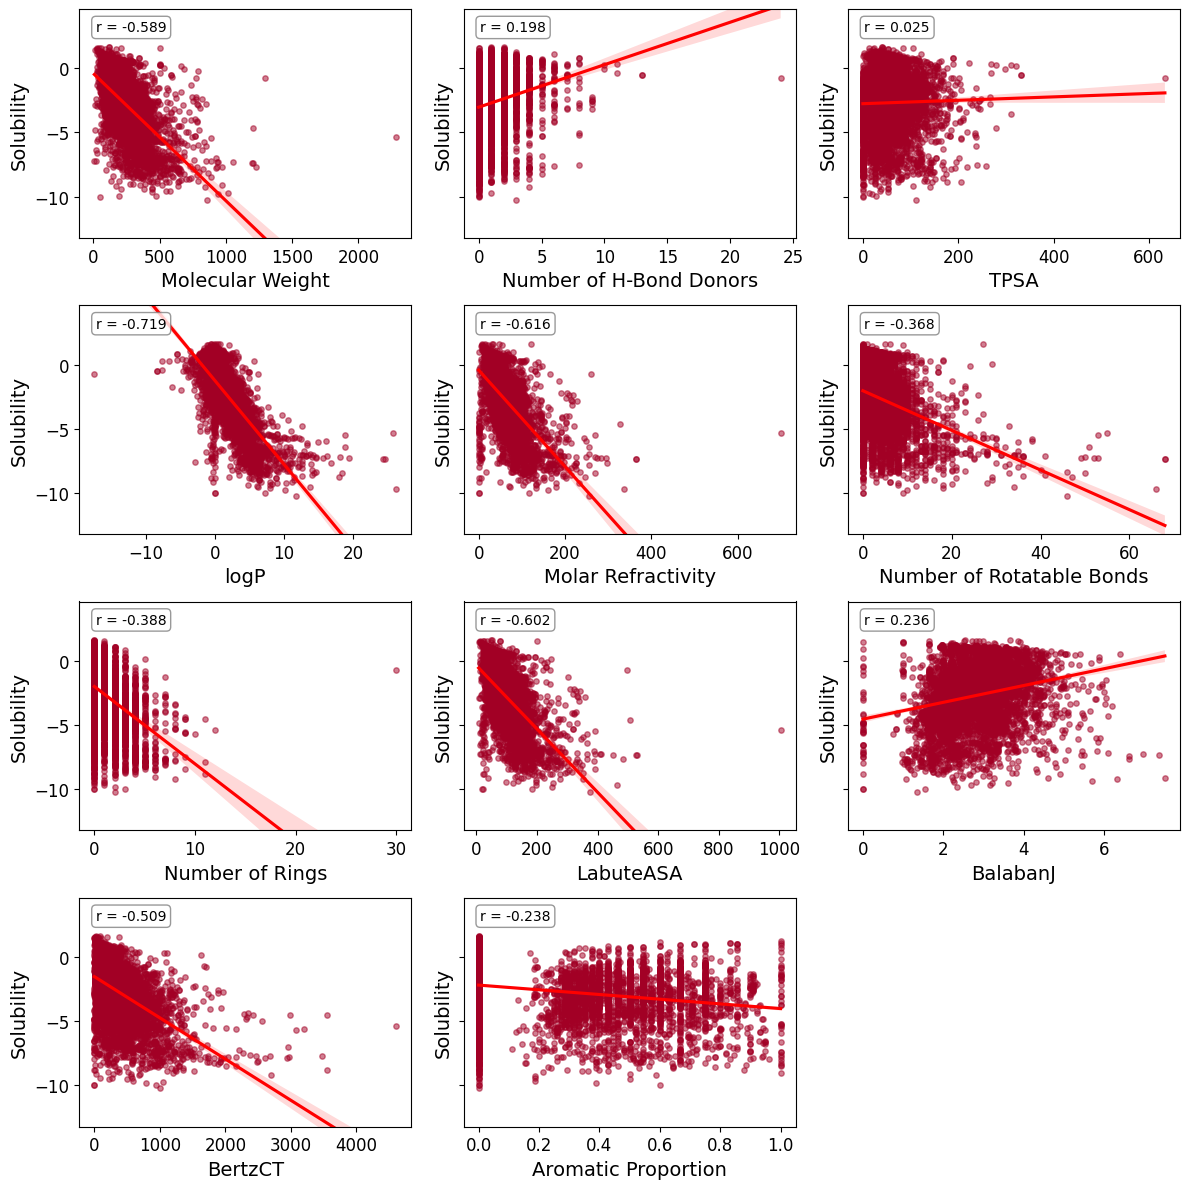

In [26]:
def visualize_descriptor_relationships(df, target_col="Y", desc_cols=None):
    """
    Visualize relationships between descriptors and the target variable.
    
    Parameters:
        df (pandas.DataFrame): DataFrame with descriptors and target
        target_col (str): Column name for the target variable
        desc_cols (list): List of descriptor column names
        
    Returns:
        matplotlib.figure.Figure: Figure with visualizations
    """
    if desc_cols is None:
        # Use all numeric columns except specific ones to exclude
        exclude_cols = [target_col, 'fragment_count']
        desc_cols = [col for col in df.select_dtypes(include=np.number).columns 
                    if col not in exclude_cols]
    
    # Determine grid dimensions
    n_cols = 3
    n_rows = (len(desc_cols) + n_cols - 1) // n_cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(12, 3*n_rows))
    axes = axes.flatten()
    
    # Create a scatter plot for each descriptor
    for i, desc in enumerate(desc_cols):
        if i < len(axes):
            ax = axes[i]
            
            # Create scatter plot with linear regression line
            sns.regplot(
                x=desc, 
                y=target_col, 
                data=df, 
                scatter_kws={"alpha": 0.5, "s": 15},
                line_kws={"color": "red"},
                ax=ax
            )
            
            # Calculate correlation
            corr = df[[desc, target_col]].corr().iloc[0, 1]
            
            # Add correlation to plot
            ax.annotate(
                f"r = {corr:.3f}",
                xy=(0.05, 0.95),
                xycoords='axes fraction',
                ha='left',
                va='top',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
            )

            ax.set_ylabel("Solubility")
            ax.set_ylim(df[target_col].min() - 3, df[target_col].max() + 3)
            
            #ax.set_title(desc)
    
    # Hide any unused subplots
    for i in range(len(desc_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('figures/ch04/scatterplot_eda.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch04/scatterplot_eda.pdf', bbox_inches='tight', dpi=600)
    
    return fig

# Get descriptor columns (exclude non-descriptor columns)
descriptor_cols = [
    'Molecular Weight', 'Number of H-Bond Donors', 'TPSA', 
    'logP', 'Molar Refractivity', 'Number of Rotatable Bonds',
    'Number of Rings', 'LabuteASA', 'BalabanJ', 'BertzCT',
    'Aromatic Proportion'
]

# Check which columns are actually in the dataframe
available_cols = [col for col in descriptor_cols if col in train_df.columns]

desc_rel_fig = visualize_descriptor_relationships(train_df, desc_cols=available_cols)

Let's create a correlation heatmap to visualize the relationships between all descriptors and solubility.

In [ ]:
def create_correlation_heatmap(df, target_col="Y", desc_cols=None):
    """
    Create a correlation heatmap for descriptors and target.
    
    Parameters:
        df (pandas.DataFrame): DataFrame with descriptors and target
        target_col (str): Column name for the target variable
        desc_cols (list): List of descriptor column names
        
    Returns:
        matplotlib.figure.Figure: Figure with heatmap
    """
    if desc_cols is None:
        # Use all numeric columns except specific ones to exclude
        exclude_cols = ['fragment_count']
        desc_cols = [col for col in df.select_dtypes(include=np.number).columns 
                    if col not in exclude_cols]
    
    # Include target variable in correlation matrix
    cols_to_use = desc_cols + [target_col]
    
    # Calculate correlation matrix
    corr_matrix = df[cols_to_use].corr()
    
    # Rename target column for better readability
    corr_matrix = corr_matrix.rename(columns={target_col: 'Solubility'}, index={target_col: 'Solubility'})
    
    # Create mask for upper triangle
    mask = np.triu(corr_matrix)
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        corr_matrix,
        cmap=sns.diverging_palette(220, 20, as_cmap=True),
        mask=mask,
        linewidth=.5,
        annot=True,
        fmt='.2f',
        vmin=-1,
        vmax=1,
        cbar_kws={
            'label': 'Correlation',
            'location': 'top',
            'orientation': 'horizontal',
            'pad': 0.01,
        }
    )
    
    # Adjust font size
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    
    # Add a title
    plt.title('Correlation Between Molecular Descriptors and Solubility', fontsize=16, pad=20)
    
    # Save the figure
    plt.savefig('figures/ch04/heatmap_eda.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch04/heatmap_eda.pdf', bbox_inches='tight', dpi=600)
    
    return plt.gcf()

# Get descriptor columns (exclude non-descriptor columns)
descriptor_cols = [
    'Molecular Weight', 'Number of H-Bond Donors', 'TPSA', 
    'logP', 'Molar Refractivity', 'Number of Rotatable Bonds',
    'Number of Rings', 'LabuteASA', 'BalabanJ', 'BertzCT',
    'Aromatic Proportion'
]

# Check which columns are actually in the dataframe
available_cols = [col for col in descriptor_cols if col in train_df.columns]

corr_fig = create_correlation_heatmap(train_df, desc_cols=available_cols)

Note that the simplicity of bounding box method, as described in the book, only requires summary statistics to bound the applicability domain by the joint min and max values of each descriptor.

In [27]:
train_df.describe()

,Y,fragment_count,Molecular Weight,Number of H-Bond Donors,TPSA,logP,Molar Refractivity,Number of Rotatable Bonds,Number of Rings,LabuteASA,BalabanJ,BertzCT,Aromatic Proportion
count,6139.000000,6139.0,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000,6139.000000
mean,-2.687823,1.0,231.519567,1.037465,52.514387,2.221913,60.059111,4.188793,1.137645,93.835955,2.838501,361.566059,0.274302
std,2.177925,0.0,129.110402,1.302389,40.799635,2.395077,35.624349,5.183913,1.399430,53.060495,0.783718,344.678348,0.282455
min,-10.234717,1.0,9.012000,0.000000,0.000000,-17.406400,0.000000,0.000000,0.000000,7.504228,0.000000,0.000000,0.000000
25%,-3.970000,1.0,148.203500,0.000000,25.780000,0.866500,38.219800,1.000000,0.000000,60.327033,2.324238,132.937410,0.000000
50%,-2.446100,1.0,206.245000,1.000000,46.330000,1.947500,52.294300,3.000000,1.000000,82.504603,2.847379,280.893937,0.285714
75%,-1.199550,1.0,282.731000,2.000000,72.830000,3.222950,74.464050,5.000000,2.000000,115.451785,3.257586,476.949898,0.500000
max,1.630235,1.0,2285.676000,24.000000,633.200000,26.246600,699.523400,68.000000,30.000000,1003.761596,7.517310,4609.941412,1.000000


### <b> <font color='#A20025'> Linear Regression

Let's start with a simple linear regression model using just one descriptor (logP) to predict solubility.


2025-03-29 18:03:02,388 - INFO - Simple Linear Regression Results:
2025-03-29 18:03:02,390 - INFO - Feature: logP
2025-03-29 18:03:02,392 - INFO - Coefficient: -0.6538
2025-03-29 18:03:02,393 - INFO - Intercept: -1.2350
2025-03-29 18:03:02,395 - INFO - RMSE: 1.5135
2025-03-29 18:03:02,396 - INFO - R²: 0.5170


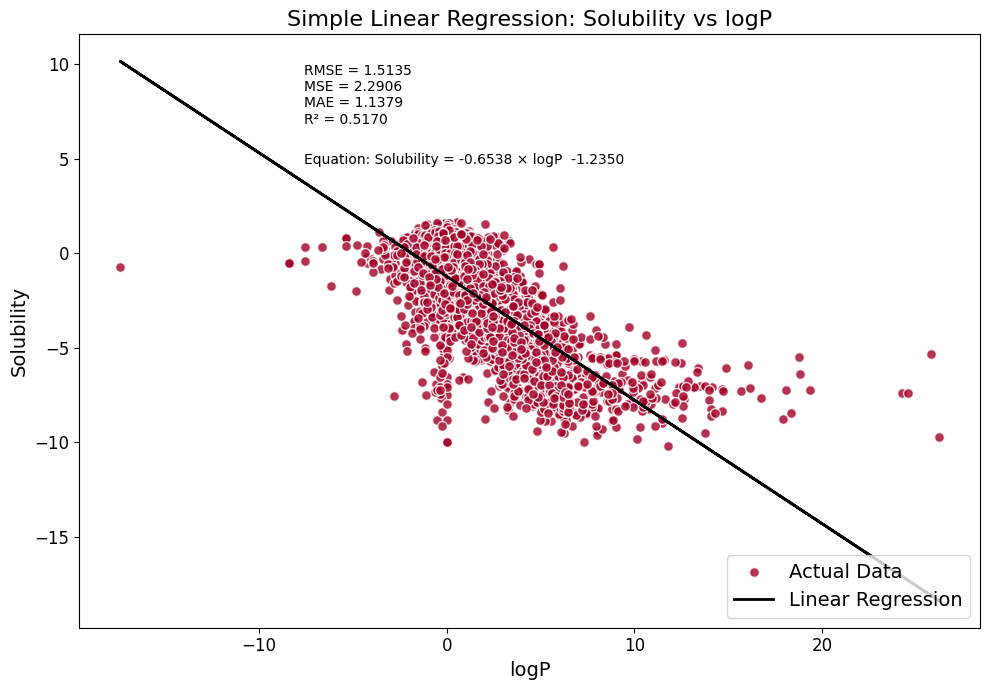

In [32]:
def build_simple_linear_model(df, feature_col='logP', target_col='Y'):
    """
    Build and evaluate a simple linear regression model.
    
    Parameters:
        df (pandas.DataFrame): DataFrame with features and target
        feature_col (str): Column name for the feature
        target_col (str): Column name for the target
        
    Returns:
        tuple: (model, X, y, predictions, metrics) Model, data, and evaluation results
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Extract features and target
    X = df[[feature_col]].values
    y = df[target_col].values
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate evaluation metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'R²': r2_score(y, y_pred),
        'Coefficients': model.coef_,
        'Intercept': model.intercept_
    }
    
    # Log results
    logger.info(f"Simple Linear Regression Results:")
    logger.info(f"Feature: {feature_col}")
    logger.info(f"Coefficient: {metrics['Coefficients'][0]:.4f}")
    logger.info(f"Intercept: {metrics['Intercept']:.4f}")
    logger.info(f"RMSE: {metrics['RMSE']:.4f}")
    logger.info(f"R²: {metrics['R²']:.4f}")
    
    return model, X, y, y_pred, metrics

def visualize_simple_linear_model(X, y, y_pred, metrics, feature_name='logP'):
    """
    Visualize a simple linear regression model.
    
    Parameters:
        X (numpy.ndarray): Feature values
        y (numpy.ndarray): True target values
        y_pred (numpy.ndarray): Predicted target values
        metrics (dict): Dictionary with evaluation metrics
        feature_name (str): Name of the feature
        
    Returns:
        matplotlib.figure.Figure: Figure with visualization
    """
    plt.figure(figsize=(10, 7))
    
    # Create scatter plot of actual data
    plt.scatter(X, y, edgecolor='white', s=50, alpha=0.8, label='Actual Data')
    
    # Add regression line
    plt.plot(X, y_pred, color='black', lw=2, label='Linear Regression')
    
    # Add metrics annotations
    plt.annotate(
        f"RMSE = {metrics['RMSE']:.4f}\n"
        f"MSE = {metrics['MSE']:.4f}\n"
        f"MAE = {metrics['MAE']:.4f}\n"
        f"R² = {metrics['R²']:.4f}",
        xy=(0.25, 0.95),
        xycoords='axes fraction',
        ha='left',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="white", alpha=0.8)
    )
    
    # Add equation of the line
    coef = metrics['Coefficients'][0]
    intercept = metrics['Intercept']
    sign = '+' if intercept >= 0 else ''
    plt.annotate(
        f"Equation: Solubility = {coef:.4f} × {feature_name} {sign} {intercept:.4f}",
        xy=(0.25, 0.80),
        xycoords='axes fraction',
        ha='left',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="white", alpha=0.8)
    )
    
    # Add labels and title
    plt.xlabel(feature_name, fontsize=14)
    plt.ylabel('Solubility', fontsize=14)
    plt.title(f'Simple Linear Regression: Solubility vs {feature_name}', fontsize=16)
    
    # Add legend
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('figures/ch04/simple_linear_regression.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch04/simple_linear_regression.pdf', bbox_inches='tight', dpi=600)
    
    return plt.gcf()

# Build model
lin_model, X_logp, y_true, y_pred, lin_metrics = build_simple_linear_model(train_df)

# Visualize model
lin_fig = visualize_simple_linear_model(X_logp, y_true, y_pred, lin_metrics)

## <b> <font color='#A20025'> 2️⃣ The Learning Algorithm

*Companion code does not accompany this section of the book.*

## <b> <font color='#A20025'> 3️⃣ Touring Scikit-Learn Linear Models

Now let's explore different types of linear models available in scikit-learn for regression problems.

### <b> <font color='#A20025'> Defining a Benchmark

Before we evaluate our models, let's establish a benchmark using the ESOL model, which is a simple linear model for predicting aqueous solubility developed by Delaney (2004).

In [ ]:
def prepare_data_for_modeling(train_df, valid_df, feature_cols=None, target_col='Y'):
    """
    Prepare data for modeling by extracting features and target.
    
    Parameters:
        train_df (pandas.DataFrame): Training data
        valid_df (pandas.DataFrame): Validation data
        feature_cols (list): List of feature column names
        target_col (str): Target column name
        
    Returns:
        tuple: (X_train, X_val, y_train, y_val) Data arrays
    """
    if feature_cols is None:
        # Use all available descriptor columns
        descriptor_cols = [
            'Molecular Weight', 'Number of H-Bond Donors', 'TPSA', 
            'logP', 'Molar Refractivity', 'Number of Rotatable Bonds',
            'Number of Rings', 'LabuteASA', 'BalabanJ', 'BertzCT',
            'Aromatic Proportion'
        ]
        
        # Check which columns are actually in the dataframe
        feature_cols = [col for col in descriptor_cols if col in train_df.columns]
    
    # Extract features and target
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values
    
    X_val = valid_df[feature_cols].values
    y_val = valid_df[target_col].values
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    logger.info(f"Prepared data with {len(feature_cols)} features")
    logger.info(f"Training set: {X_train.shape[0]} samples")
    logger.info(f"Validation set: {X_val.shape[0]} samples")
    
    return X_train_scaled, X_val_scaled, y_train, y_val, scaler

def apply_esol_model(df, original_coeffs=True):
    """
    Apply the ESOL model to predict solubility.
    
    Parameters:
        df (pandas.DataFrame): DataFrame with required descriptors
        original_coeffs (bool): Whether to use original coefficients or refit
        
    Returns:
        numpy.ndarray: Predicted solubility values
    """
    # Check if required columns are present
    required_cols = ['logP', 'Molecular Weight', 'Number of Rotatable Bonds', 'Aromatic Proportion']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        logger.error(f"Missing required columns for ESOL: {missing_cols}")
        return None
    
    # Original ESOL coefficients from Delaney (2004)
    if original_coeffs:
        intercept = 0.16
        logp_coef = -0.63
        mw_coef = -0.0062
        rb_coef = 0.066
        ap_coef = -0.74
    else:
        # Refit on our data (values from chapter code)
        intercept = 0.26
        logp_coef = -0.74
        mw_coef = -0.0034
        rb_coef = 0.034
        ap_coef = -0.42
    
    # Apply the model
    predictions = (
        intercept +
        logp_coef * df['logP'] +
        mw_coef * df['Molecular Weight'] +
        rb_coef * df['Number of Rotatable Bonds'] +
        ap_coef * df['Aromatic Proportion']
    )
    
    return predictions

def evaluate_esol_benchmark(valid_df, target_col='Y'):
    """
    Evaluate the ESOL model as a benchmark.
    
    Parameters:
        valid_df (pandas.DataFrame): Validation data
        target_col (str): Target column name
        
    Returns:
        tuple: (original_rmse, refit_rmse) RMSE values for original and refit models
    """
    # Check if we have overlap with Delaney's dataset
    has_delaney_overlap = False
    
    try:
        # Try to load Delaney's dataset
        delaney_df = pd.read_csv("data/ch04/delaney_solubility.txt", sep=',')
        
        if 'Molecule' in valid_df.columns:
            # Add InChI keys for comparison
            from rdkit.Chem import MolToInchiKey
            
            valid_df = valid_df.copy()
            valid_df['Inchi'] = valid_df['Molecule'].apply(
                lambda x: MolToInchiKey(x) if x is not None else None
            )
            
            delaney_df['Inchi'] = delaney_df['SMILES'].apply(
                lambda x: MolToInchiKey(MolFromSmiles(x)) if pd.notna(x) else None
            )
            
            # Find molecules that are in both datasets
            merged = pd.merge(valid_df, delaney_df, how="outer", on="Inchi", indicator=True)
            overlap = merged[merged['_merge'] == 'both']
            
            if len(overlap) > 0:
                logger.info(f"Found {len(overlap)} molecules in common with Delaney's dataset")
                has_delaney_overlap = True
                
                # Exclude overlapping molecules
                valid_df_excl = valid_df[~valid_df['Inchi'].isin(overlap['Inchi'])]
                logger.info(f"Using {len(valid_df_excl)} non-overlapping molecules for ESOL evaluation")
            else:
                logger.info("No overlap found with Delaney's dataset")
                valid_df_excl = valid_df
        else:
            logger.warning("No 'Molecule' column found, skipping overlap check")
            valid_df_excl = valid_df
            
    except Exception as e:
        logger.warning(f"Error checking Delaney overlap: {str(e)}")
        valid_df_excl = valid_df
    
    # Apply ESOL models
    y_true = valid_df_excl[target_col]
    
    y_pred_original = apply_esol_model(valid_df_excl, original_coeffs=True)
    y_pred_refit = apply_esol_model(valid_df_excl, original_coeffs=False)
    
    # Calculate RMSE
    rmse_original = np.sqrt(mean_squared_error(y_true, y_pred_original))
    rmse_refit = np.sqrt(mean_squared_error(y_true, y_pred_refit))
    
    logger.info(f"ESOL Benchmark RMSE (original coefficients): {rmse_original:.4f}")
    logger.info(f"ESOL Benchmark RMSE (refitted coefficients): {rmse_refit:.4f}")
    
    return rmse_original, rmse_refit

# Prepare data
X_train, X_val, y_train, y_val, feature_scaler = prepare_data_for_modeling(train_df, valid_df)

# Evaluate ESOL benchmark
original_rmse, refit_rmse = evaluate_esol_benchmark(valid_df)


2025-03-29 18:06:02,313 - INFO - Prepared data with 11 features
2025-03-29 18:06:02,316 - INFO - Training set: 6139 samples
2025-03-29 18:06:02,318 - INFO - Validation set: 921 samples
2025-03-29 18:06:04,200 - INFO - Found 135 molecules in common with Delaney's dataset
2025-03-29 18:06:04,204 - INFO - Using 791 non-overlapping molecules for ESOL evaluation
2025-03-29 18:06:04,211 - INFO - ESOL Benchmark RMSE (original coefficients): 1.4579
2025-03-29 18:06:04,212 - INFO - ESOL Benchmark RMSE (refitted coefficients): 1.7720


### <b> <font color='#A20025'> Ridge Regression & Feature Selection


Now let's implement Ridge regression, which adds L2 regularization to linear regression to prevent overfitting.


In [47]:
def tune_ridge_regression(X_train, X_val, y_train, y_val):
    """
    Tune a Ridge regression model with grid search.
    
    Parameters:
        X_train (numpy.ndarray): Training features
        X_val (numpy.ndarray): Validation features
        y_train (numpy.ndarray): Training target
        y_val (numpy.ndarray): Validation target
        
    Returns:
        tuple: (model, train_metrics, val_metrics) Model and evaluation metrics
    """
    from scipy.stats import uniform as sp_rand
    
    # Parameter distribution for random search
    param_dist = {
        'ridge__alpha': sp_rand()
    }
    
    # Create a pipeline with imputation and standardization
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('standardscaler', StandardScaler(with_mean=True, with_std=True)),
        ('ridge', Ridge()),
    ])
    
    # Perform random search
    rs_estimator = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        scoring="neg_mean_squared_error",
        cv=5,
        n_iter=20,
        random_state=RANDOM_SEED
    )
    
    # Fit the model
    rs_estimator.fit(X_train, y_train)
    
    # Get the best model
    best_ridge_estimator = rs_estimator.best_estimator_
    
    # Evaluate the model
    y_train_pred = best_ridge_estimator.predict(X_train)
    y_val_pred = best_ridge_estimator.predict(X_val)
    
    # Calculate metrics
    train_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'R²': r2_score(y_train, y_train_pred)
    }
    
    val_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'R²': r2_score(y_val, y_val_pred)
    }
    
    # Log results
    logger.info(f"Best Ridge alpha: {rs_estimator.best_params_['ridge__alpha']:.6f}")
    logger.info(f"Training RMSE: {train_metrics['RMSE']:.4f}, R²: {train_metrics['R²']:.4f}")
    logger.info(f"Validation RMSE: {val_metrics['RMSE']:.4f}, R²: {val_metrics['R²']:.4f}")
    
    return best_ridge_estimator, train_metrics, val_metrics

def visualize_ridge_coefficients(model, feature_names):
    """
    Visualize Ridge regression coefficients.
    
    Parameters:
        model (Pipeline): Trained Ridge regression pipeline
        feature_names (list): List of feature names
        
    Returns:
        matplotlib.figure.Figure: Figure with visualization
    """
    # Extract coefficients from the model
    ridge_model = model.named_steps['ridge']
    coefficients = ridge_model.coef_
    
    # Sort coefficients by absolute value
    sorted_idx = np.argsort(np.abs(coefficients))[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_coefficients = coefficients[sorted_idx]
    
    # Create barplot
    plt.figure(figsize=(14, 8))
    
    colors = np.where(np.array(sorted_coefficients) >= 0, "#6C8EBF", "#A20025")
    bars = plt.barh(
        range(len(sorted_coefficients)), 
        sorted_coefficients, 
        align='center',
        color=colors,
        linewidth=2,
        edgecolor=".1"
    )
    
    # Add feature names to y-axis
    plt.yticks(range(len(sorted_coefficients)), sorted_features)
    
    # Add value labels to bars
    for i, bar in enumerate(bars):
        plt.text(
            bar.get_width() * 1.05 if bar.get_width() > 0 else bar.get_width() * 1.05,
            i,
            f"{sorted_coefficients[i]:.2f}",
            ha='left' if bar.get_width() > 0 else 'right',
            va='center',
            fontsize=10
        )
    
    # Add labels and title
    plt.xlabel('Coefficient Value', fontsize=14)
    plt.title('Ridge Regression Coefficients (Feature Importance)', fontsize=16)
    
    # Add vertical line at zero
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('figures/ch04/ridge_regressor_features.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch04/ridge_regressor_features.pdf', bbox_inches='tight', dpi=600)
    
    return plt.gcf()

# Tune Ridge regression
ridge_model, ridge_train_metrics, ridge_val_metrics = tune_ridge_regression(
    X_train, X_val, y_train, y_val
)

2025-03-29 18:15:59,403 - INFO - Best Ridge alpha: 0.969910
2025-03-29 18:15:59,405 - INFO - Training RMSE: 1.3687, R²: 0.6050
2025-03-29 18:15:59,405 - INFO - Validation RMSE: 1.4890, R²: 0.6990


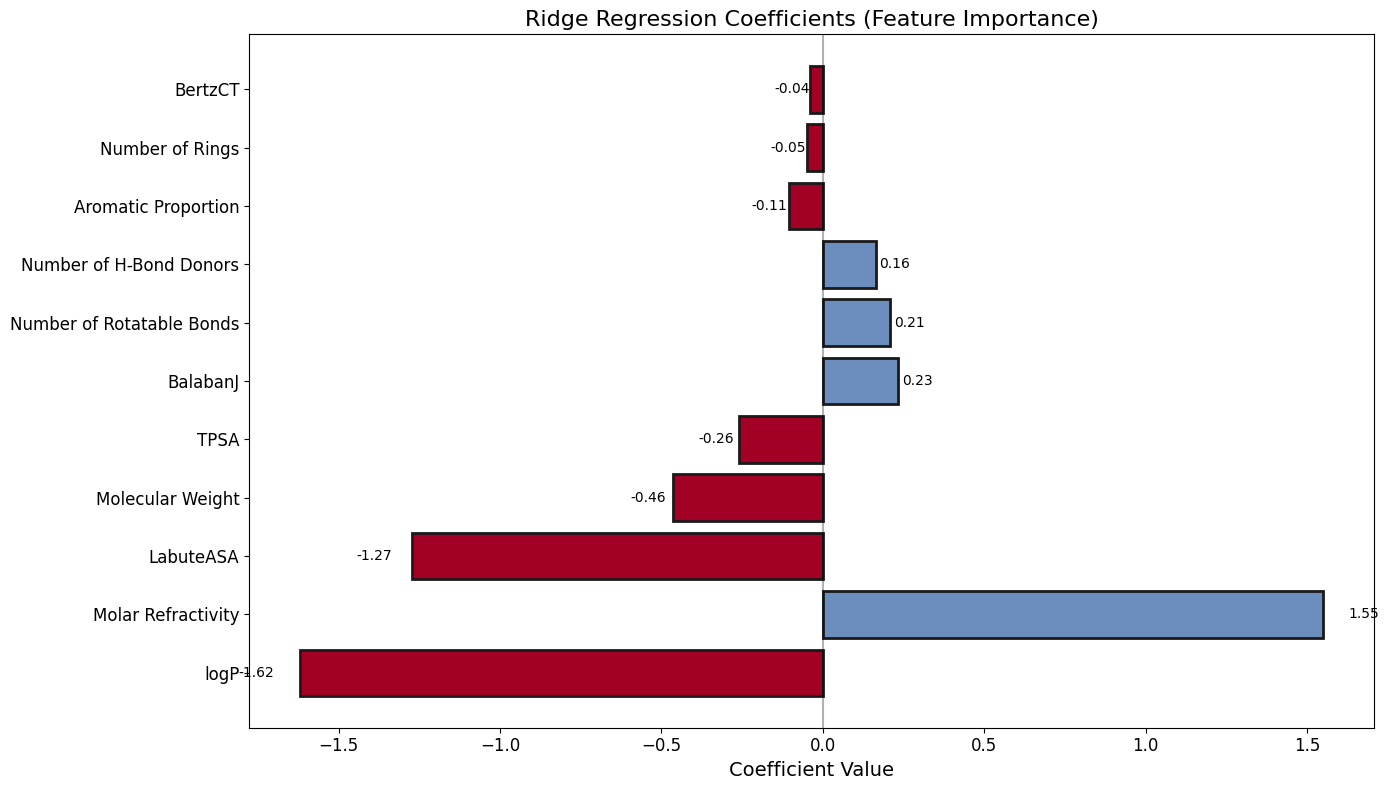

In [48]:
# Get feature names
feature_names = [
    'Molecular Weight', 'Number of H-Bond Donors', 'TPSA', 
    'logP', 'Molar Refractivity', 'Number of Rotatable Bonds',
    'Number of Rings', 'LabuteASA', 'BalabanJ', 'BertzCT',
    'Aromatic Proportion'
]

# Check which features were actually used
available_features = [col for col in feature_names if col in train_df.columns]

# Visualize coefficients
ridge_coef_fig = visualize_ridge_coefficients(ridge_model, available_features)

Let's use sequential feature selection to identify the most informative features for our model.


In [52]:
def sequential_feature_selection(X_train, X_val, y_train, y_val, feature_names):
    """
    Perform sequential feature selection with RidgeCV.
    
    Parameters:
        X_train (numpy.ndarray): Training features
        X_val (numpy.ndarray): Validation features
        y_train (numpy.ndarray): Training target
        y_val (numpy.ndarray): Validation target
        feature_names (list): List of feature names
        
    Returns:
        tuple: (model, selected_features, metrics) Model, features, and metrics
    """
    # Create feature selector
    ridge_cv = RidgeCV(alphas=np.logspace(-4, 1, 10))
    
    forward_selector = SequentialFeatureSelector(
        ridge_cv,
        n_features_to_select="auto",
        tol=1e-3,
        direction="forward",
        scoring="neg_mean_squared_error",
    )
    
    # Create pipeline
    model = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(),
        forward_selector,
        RidgeCV(alphas=np.logspace(-4, 1, 10))
    )
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Get selected features
    selected_indices = model[2].get_support()
    selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_indices[i]]
    
    # Log results
    logger.info(f"Selected features: {selected_features}")
    logger.info(f"Best alpha: {model[3].alpha_:.6f}")
    
    # Evaluate the model
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    train_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'R²': r2_score(y_train, y_train_pred)
    }
    
    val_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'R²': r2_score(y_val, y_val_pred)
    }
    
    logger.info(f"Training RMSE: {train_metrics['RMSE']:.4f}, R²: {train_metrics['R²']:.4f}")
    logger.info(f"Validation RMSE: {val_metrics['RMSE']:.4f}, R²: {val_metrics['R²']:.4f}")
    
    return model, selected_features, train_metrics, val_metrics

# Get feature names
feature_names = [
    'Molecular Weight', 'Number of H-Bond Donors', 'TPSA', 
    'logP', 'Molar Refractivity', 'Number of Rotatable Bonds',
    'Number of Rings', 'LabuteASA', 'BalabanJ', 'BertzCT',
    'Aromatic Proportion'
]

# Check which features were actually used
available_features = [col for col in feature_names if col in train_df.columns]

# Perform feature selection
selected_model, selected_features, sel_train_metrics, sel_val_metrics = sequential_feature_selection(
    X_train, X_val, y_train, y_val, available_features
)

2025-03-29 18:30:31,315 - INFO - Selected features: ['Molecular Weight', 'logP', 'Molar Refractivity', 'Number of Rotatable Bonds', 'LabuteASA', 'BalabanJ', 'BertzCT']
2025-03-29 18:30:31,316 - INFO - Best alpha: 0.774264
2025-03-29 18:30:31,337 - INFO - Training RMSE: 1.3757, R²: 0.6009
2025-03-29 18:30:31,340 - INFO - Validation RMSE: 1.4966, R²: 0.6959


### <b> <font color='#A20025'> Robust Estimation with RANSAC

Let's use RANSAC (RANdom SAmple Consensus) regression, which is robust to outliers by fitting a model to a subset of inliers.

In [53]:
def train_ransac_regressor(X_train, X_val, y_train, y_val, selected_features=None, feature_names=None):
    """
    Train a RANSAC regressor.
    
    Parameters:
        X_train (numpy.ndarray): Training features
        X_val (numpy.ndarray): Validation features
        y_train (numpy.ndarray): Training target
        y_val (numpy.ndarray): Validation target
        selected_features (list): List of selected feature names
        feature_names (list): List of all feature names
        
    Returns:
        tuple: (model, train_metrics, val_metrics) Model and evaluation metrics
    """
    # If selected_features is provided, use only those features
    if selected_features is not None and feature_names is not None:
        # Get indices of selected features
        selected_indices = [feature_names.index(feat) for feat in selected_features]
        
        # Select features
        X_train_selected = X_train[:, selected_indices]
        X_val_selected = X_val[:, selected_indices]
        
        logger.info(f"Using {len(selected_features)} selected features")
    else:
        X_train_selected = X_train
        X_val_selected = X_val
        logger.info("Using all features")
    
    # Create RANSAC pipeline
    ransac_regressor = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('standardscaler', StandardScaler()),
        ('ransac', RANSACRegressor(
            estimator=LinearRegression(),
            max_trials=200,
            min_samples=0.95,
            random_state=RANDOM_SEED
        )),
    ])
    
    # Fit the model
    ransac_regressor.fit(X_train_selected, y_train)
    
    # Evaluate the model
    y_train_pred = ransac_regressor.predict(X_train_selected)
    y_val_pred = ransac_regressor.predict(X_val_selected)
    
    # Calculate metrics
    train_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'R²': r2_score(y_train, y_train_pred)
    }
    
    val_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'R²': r2_score(y_val, y_val_pred)
    }
    
    # Extract coefficients
    if hasattr(ransac_regressor.named_steps['ransac'].estimator_, 'coef_'):
        coefficients = ransac_regressor.named_steps['ransac'].estimator_.coef_
        intercept = ransac_regressor.named_steps['ransac'].estimator_.intercept_
        
        if selected_features is not None:
            coef_dict = dict(zip(selected_features, coefficients))
        else:
            coef_dict = dict(zip(feature_names, coefficients))
        
        # Sort by absolute value
        sorted_coeffs = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        
        logger.info("RANSAC Coefficients (sorted by importance):")
        for feat, coef in sorted_coeffs:
            logger.info(f"{feat}: {coef:.4f}")
        
        logger.info(f"Intercept: {intercept:.4f}")
    
    logger.info(f"Training RMSE: {train_metrics['RMSE']:.4f}, R²: {train_metrics['R²']:.4f}")
    logger.info(f"Validation RMSE: {val_metrics['RMSE']:.4f}, R²: {val_metrics['R²']:.4f}")
    
    return ransac_regressor, train_metrics, val_metrics

# Get feature names
feature_names = [
    'Molecular Weight', 'Number of H-Bond Donors', 'TPSA', 
    'logP', 'Molar Refractivity', 'Number of Rotatable Bonds',
    'Number of Rings', 'LabuteASA', 'BalabanJ', 'BertzCT',
    'Aromatic Proportion'
]

# Check which features were actually used
available_features = [col for col in feature_names if col in train_df.columns]

# Train RANSAC regressor
ransac_model, ransac_train_metrics, ransac_val_metrics = train_ransac_regressor(
    X_train, X_val, y_train, y_val, selected_features, available_features
)

2025-03-29 18:30:43,820 - INFO - Using 7 selected features
2025-03-29 18:30:44,503 - INFO - RANSAC Coefficients (sorted by importance):
2025-03-29 18:30:44,504 - INFO - logP: -1.6084
2025-03-29 18:30:44,506 - INFO - Molar Refractivity: 1.4246
2025-03-29 18:30:44,507 - INFO - LabuteASA: -1.2463
2025-03-29 18:30:44,508 - INFO - Molecular Weight: -0.4536
2025-03-29 18:30:44,511 - INFO - BertzCT: -0.4014
2025-03-29 18:30:44,512 - INFO - Number of Rotatable Bonds: 0.2303
2025-03-29 18:30:44,513 - INFO - BalabanJ: 0.1075
2025-03-29 18:30:44,515 - INFO - Intercept: -2.6598
2025-03-29 18:30:44,518 - INFO - Training RMSE: 1.3963, R²: 0.5889
2025-03-29 18:30:44,519 - INFO - Validation RMSE: 1.4554, R²: 0.7124


In [55]:
sorted(zip(ransac_model.named_steps["ransac"].estimator_.coef_, selected_features), reverse=True)

[(1.4245770561491882, 'Molar Refractivity'),
 (0.23033442362400158, 'Number of Rotatable Bonds'),
 (0.10754757507627688, 'BalabanJ'),
 (-0.401427278304344, 'BertzCT'),
 (-0.45355007850366313, 'Molecular Weight'),
 (-1.2463111351549596, 'LabuteASA'),
 (-1.608351866782995, 'logP')]

### <b> <font color='#A20025'> Support Vector Regression

Let's explore Support Vector Regression (SVR) using the SGDRegressor with different loss functions.

In [76]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svr__loss' : ['squared_error', 'huber', 'epsilon_insensitive'],
    'svr__alpha' : np.logspace(-6, 2, num=9),
    'svr__learning_rate' : ['invscaling', 'adaptive'],
    'svr__early_stopping' : [True, False],
    'svr__penalty' : ['l2', None],
    'polynomialfeatures__degree' : [1, 2],
}

pipe = Pipeline([
  ('imputer', SimpleImputer(strategy="median")),
  ('polynomialfeatures', PolynomialFeatures()),
  ('standardscaler', StandardScaler()),
  ('svr', SGDRegressor(max_iter=1000, tol=1e-3, random_state=RANDOM_SEED)),
])

rs_estimator = GridSearchCV(
  estimator=pipe,
  param_grid=param_grid,
  scoring="neg_mean_squared_error",
  cv=5,
)

# Get indices of selected features
#selected_indices = [feature_names.index(feat) for feat in selected_features]

# Select features
#X_train_selected = X_train[:, selected_indices]

rs_estimator.fit(X_train, y_train)

/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_it

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('svr', SGDRegressor(random_state=42))]),
             param_grid={'polynomialfeatures__degree': [1, 2],
                         'svr__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02]),
                         'svr__early_stopping': [True, False],
                         'svr__learning_rate': ['invscaling', 'adaptive'],
                         'svr__loss': ['squared_error', 'huber',
                                       'epsilon_insensitive'],
                         'svr__penalty': ['l2', None]},
             scoring='neg_mean_squared_error')

In [77]:
best_svr_estimator = rs_estimator.best_estimator_
y_train_preds = best_svr_estimator.predict(X_train)
y_val_preds = best_svr_estimator.predict(X_val)

In [78]:
rs_estimator.best_params_

{'polynomialfeatures__degree': 1,
 'svr__alpha': 0.001,
 'svr__early_stopping': False,
 'svr__learning_rate': 'invscaling',
 'svr__loss': 'squared_error',
 'svr__penalty': 'l2'}

In [79]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_preds))

print(f"Train RMSE: {train_rmse:.4f}\nValidation RMSE: {val_rmse:.4f}")

Train RMSE: 1.3786
Validation RMSE: 1.5014


**Code for Figure 4.17. Connection to Stochastic Gradient Descent**

In [80]:
sgd_regressor = make_pipeline(
  SimpleImputer(strategy="median"),
  PolynomialFeatures(degree=2),
  StandardScaler(),
  SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='invscaling', loss="epsilon_insensitive", penalty='l2'),
)

epochs = range(1, 30)
train_losses, train_losses_constant_lr = [], []
val_losses, val_losses_constant_lr = [], []

def epsilon_insensitive_loss(y_true, y_pred, epsilon=0.1):
    # Calculate absolute differences between predicted and actual values
    absolute_diff = np.abs(y_true - y_pred)

    # Compute the loss with epsilon-insensitive margin
    loss = np.maximum(0, absolute_diff - epsilon)

    return np.mean(loss)

for epoch in epochs:
  sgd_regressor.set_params(sgdregressor__max_iter=epoch, sgdregressor__early_stopping=False)
  sgd_regressor.fit(X_train, y_train)
  y_train_preds = sgd_regressor.predict(X_train)
  y_val_preds = sgd_regressor.predict(X_val)
  train_losses.append(epsilon_insensitive_loss(y_train, y_train_preds))
  val_losses.append(epsilon_insensitive_loss(y_val, y_val_preds))

  sgd_regressor.set_params(sgdregressor__max_iter=epoch, sgdregressor__early_stopping=False, sgdregressor__learning_rate='constant')
  sgd_regressor.fit(X_train, y_train)
  y_train_preds = sgd_regressor.predict(X_train)
  y_val_preds = sgd_regressor.predict(X_val)
  train_losses_constant_lr.append(epsilon_insensitive_loss(y_train, y_train_preds))
  val_losses_constant_lr.append(epsilon_insensitive_loss(y_val, y_val_preds))

/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_it

/tmp/ipykernel_4249/2940966558.py:1: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


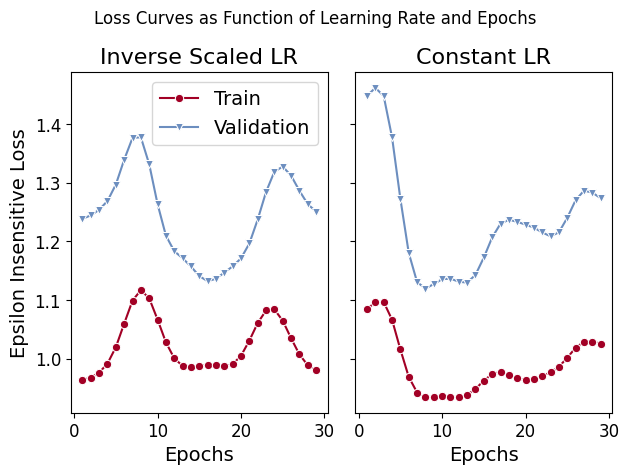

In [81]:
from scipy.ndimage.filters import gaussian_filter1d

fig, axes =plt.subplots(1, 2, sharey=True)
fig.suptitle("Loss Curves as Function of Learning Rate and Epochs")

sns.lineplot(ax=axes[0], x=epochs, y=gaussian_filter1d(train_losses, sigma=2), marker="o", label="Train")
sns.lineplot(ax=axes[0], x=epochs, y=gaussian_filter1d(val_losses, sigma=2), marker="v", label="Validation")
axes[0].set_title("Inverse Scaled LR")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Epsilon Insensitive Loss")

sns.lineplot(ax=axes[1], x=epochs, y=gaussian_filter1d(train_losses_constant_lr, sigma=2), marker="o")
sns.lineplot(ax=axes[1], x=epochs, y=gaussian_filter1d(val_losses_constant_lr, sigma=2), marker="v")
axes[1].set_title("Constant LR")
axes[1].set_xlabel("Epochs")

fig.tight_layout()
axes[0].legend(handles=axes[0].get_legend_handles_labels()[0], labels=["Train", "Validation"])
plt.savefig("figures/ch04/sgd_loss_curves.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch04/sgd_loss_curves.png", bbox_inches='tight', dpi=600)

**Evaluation of final, best performing model on test data and against ESOL and y-scrambled baselines**

### <b> <font color='#A20025'> Final Model Evaluation on Test Set

Now let's evaluate our best model on the test set to get a final assessment of its performance, comparing it against ESOL and y-scrambled baselines.

In [83]:
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

sgd_regressor = make_pipeline(
  SimpleImputer(strategy="median"),
  PolynomialFeatures(degree=2),
  StandardScaler(),
  SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='invscaling', loss="epsilon_insensitive", penalty='l2'),
)

sgd_regressor.fit(X, y)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.1, early_stopping=True,
                              loss='epsilon_insensitive'))])

In [91]:
test_df = add_molecule_objects(test_df)
test_df = check_molecule_fragments(test_df)
test_df_filtered = test_df[(test_df['fragment_count'] == 1) & (test_df['Molecule'].notnull())]
test_df = test_df_filtered.copy()
test_df = calculate_molecular_descriptors(test_df)


2025-03-31 19:38:57,114 - INFO - Converting SMILES to RDKit molecules...
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNING: not removing hydrogen atom without neighbors
[19:38:57] WARNIN

  0%|          | 0/11 [00:00<?, ?it/s]

In [93]:
target_col = 'Y'
descriptor_cols = [
            'Molecular Weight', 'Number of H-Bond Donors', 'TPSA', 
            'logP', 'Molar Refractivity', 'Number of Rotatable Bonds',
            'Number of Rings', 'LabuteASA', 'BalabanJ', 'BertzCT',
            'Aromatic Proportion'
        ]
    
# Check which columns are actually in the dataframe
feature_cols = [col for col in descriptor_cols if col in train_df.columns]

# Extract features and target
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Scale features
X_test = feature_scaler.transform(X_test)

In [ ]:
def evaluate_final_model(model, X_test, y_test, model_name="SGD Regressor (SVR)"):
    """
    Evaluate the final model on the test set.
    
    Parameters:
        model (object): Trained model
        X_test (numpy.ndarray): Test features
        y_test (numpy.ndarray): Test target
        model_name (str): Name of the model
        
    Returns:
        dict: Evaluation metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    test_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }
    
    # Log results
    logger.info(f"{model_name} Test RMSE: {test_metrics['RMSE']:.4f}")
    logger.info(f"{model_name} Test MAE: {test_metrics['MAE']:.4f}")
    logger.info(f"{model_name} Test R²: {test_metrics['R²']:.4f}")
    
    return test_metrics

final_metrics = evaluate_final_model(sgd_regressor, X_test, y_test)

2025-03-31 19:47:16,260 - INFO - SGD Regressor (SVR) Test RMSE: 1.2797
2025-03-31 19:47:16,265 - INFO - SGD Regressor (SVR) Test MAE: 0.9585
2025-03-31 19:47:16,267 - INFO - SGD Regressor (SVR) Test R²: 0.6825


2025-03-31 19:53:31,148 - INFO - ESOL Benchmark Test RMSE: 1.3787
2025-03-31 19:53:31,203 - INFO - Performing y-scrambling test...


  0%|          | 0/100 [00:00<?, ?it/s]

2025-03-31 19:53:38,759 - INFO - Average RMSE over 100 y-scrambled iterations: 2.4739


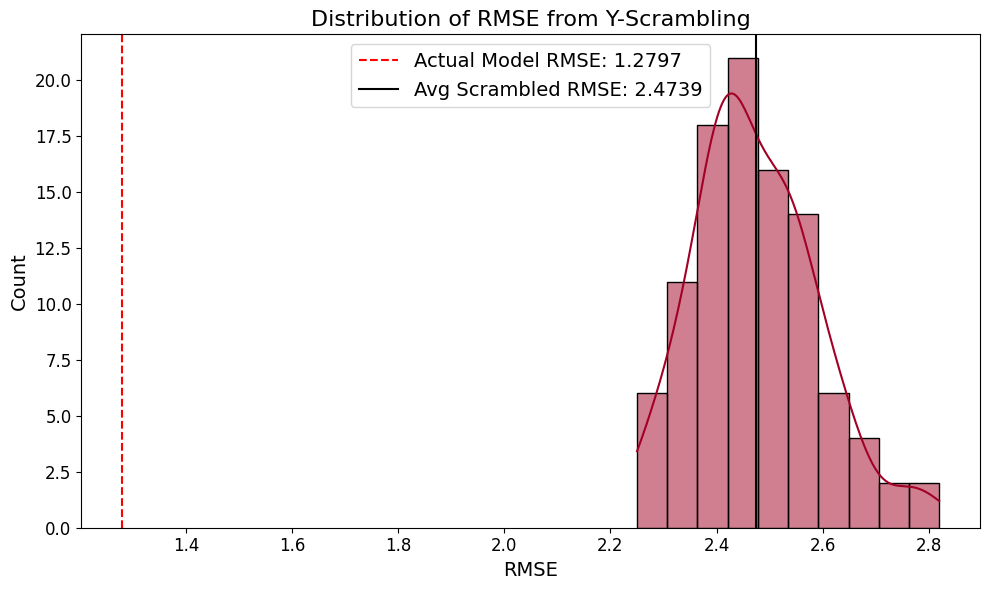

In [95]:
def compare_with_baselines(test_df, y_test, test_metrics):
    """
    Compare model performance with baselines.
    
    Parameters:
        test_df (pandas.DataFrame): Test data
        y_test (numpy.ndarray): Test target
        test_metrics (dict): Model evaluation metrics
        
    Returns:
        dict: Baseline metrics
    """
    # ESOL benchmark
    y_pred_esol = apply_esol_model(test_df, original_coeffs=True)
    esol_rmse = np.sqrt(mean_squared_error(y_test, y_pred_esol))
    
    logger.info(f"ESOL Benchmark Test RMSE: {esol_rmse:.4f}")
    
    # Y-scrambling (permutation test)
    from tqdm.notebook import trange
    
    combined_df = pd.concat([train_df, valid_df])
    if combined_df is not None:
        scrambled_rmse_values = []
        n_iterations = 100
        
        # Create and train a model with best parameters from grid search
        sgd_regressor = make_pipeline(
            SimpleImputer(strategy="median"),
            PolynomialFeatures(degree=2),
            StandardScaler(),
            SGDRegressor(
                alpha=0.1,
                early_stopping=True,
                learning_rate='invscaling',
                loss="epsilon_insensitive",
                penalty='l2'
            ),
        )
        
        logger.info("Performing y-scrambling test...")
        
        for i in trange(n_iterations):
            # Extract features and target
            X = combined_df[available_features].values
            y = combined_df["Y"].values
            
            # Scramble y
            y_scrambled = np.random.permutation(y)
            
            # Train model on scrambled data
            sgd_regressor.fit(X, y_scrambled)
            
            # Predict on test data
            y_pred = sgd_regressor.predict(X_test)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            scrambled_rmse_values.append(rmse)
        
        # Calculate statistics
        avg_scrambled_rmse = np.mean(scrambled_rmse_values)
        
        logger.info(f"Average RMSE over {n_iterations} y-scrambled iterations: {avg_scrambled_rmse:.4f}")
        
        # Create visualization
        plt.figure(figsize=(10, 6))
        sns.histplot(scrambled_rmse_values, kde=True)
        plt.axvline(x=test_metrics['RMSE'], color='red', linestyle='--', 
                   label=f'Actual Model RMSE: {test_metrics["RMSE"]:.4f}')
        plt.axvline(x=avg_scrambled_rmse, color='black', linestyle='-', 
                   label=f'Avg Scrambled RMSE: {avg_scrambled_rmse:.4f}')
        plt.xlabel('RMSE')
        plt.ylabel('Count')
        plt.title('Distribution of RMSE from Y-Scrambling')
        plt.legend()
        
        plt.tight_layout()
        
        # Save the figure
        plt.savefig('figures/ch04/y_scrambled_dist.png', bbox_inches='tight', dpi=600)
        plt.savefig('figures/ch04/y_scrambled_dist.pdf', bbox_inches='tight', dpi=600)
        
        plt.show()
        
        return {
            'ESOL RMSE': esol_rmse,
            'Avg Y-Scrambled RMSE': avg_scrambled_rmse,
            'Y-Scrambled RMSE Values': scrambled_rmse_values
        }
    else:
        return {
            'ESOL RMSE': esol_rmse
        }

baseline_metrics = compare_with_baselines(test_df, y_test, final_metrics)


## <b> <font color='#A20025'> 4️⃣ Bias-Variance Decomposition

Now let's explore the bias-variance tradeoff to understand how model complexity affects generalization.

### <b> <font color='#A20025'> A Case Study in Polynomials

Let's visualize how model complexity affects the bias-variance tradeoff using polynomial regression.

**Code for Figure 4.18. Impact of model complexity on the fitted model's training and testing performance**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline

In [ ]:
f = lambda i: -0.5 * i ** 7 - 0.3 * i ** 3 + 1.2 * i ** 2 + 0.2 * i - 1
rng = np.random.RandomState(RANDOM_SEED)
X_target = np.linspace(-1, 1, 30)
y_target = f(X_target)

y_sample = y_target + .2 * rng.normal(size=30)

X_train, X_test, y_train, y_test = train_test_split(
    X_target, y_sample, test_size=0.3, random_state=RANDOM_SEED,
)

In [ ]:
polynomial_fit_2 = make_pipeline(
  PolynomialFeatures(degree=2),
  LinearRegression(),
).fit(X_train.reshape(-1, 1), y_train)

polynomial_fit_20 = make_pipeline(
  PolynomialFeatures(degree=20),
  LinearRegression(),
).fit(X_train.reshape(-1, 1), y_train)

In [ ]:
order_train = X_train.argsort()
order_test = X_test.argsort()

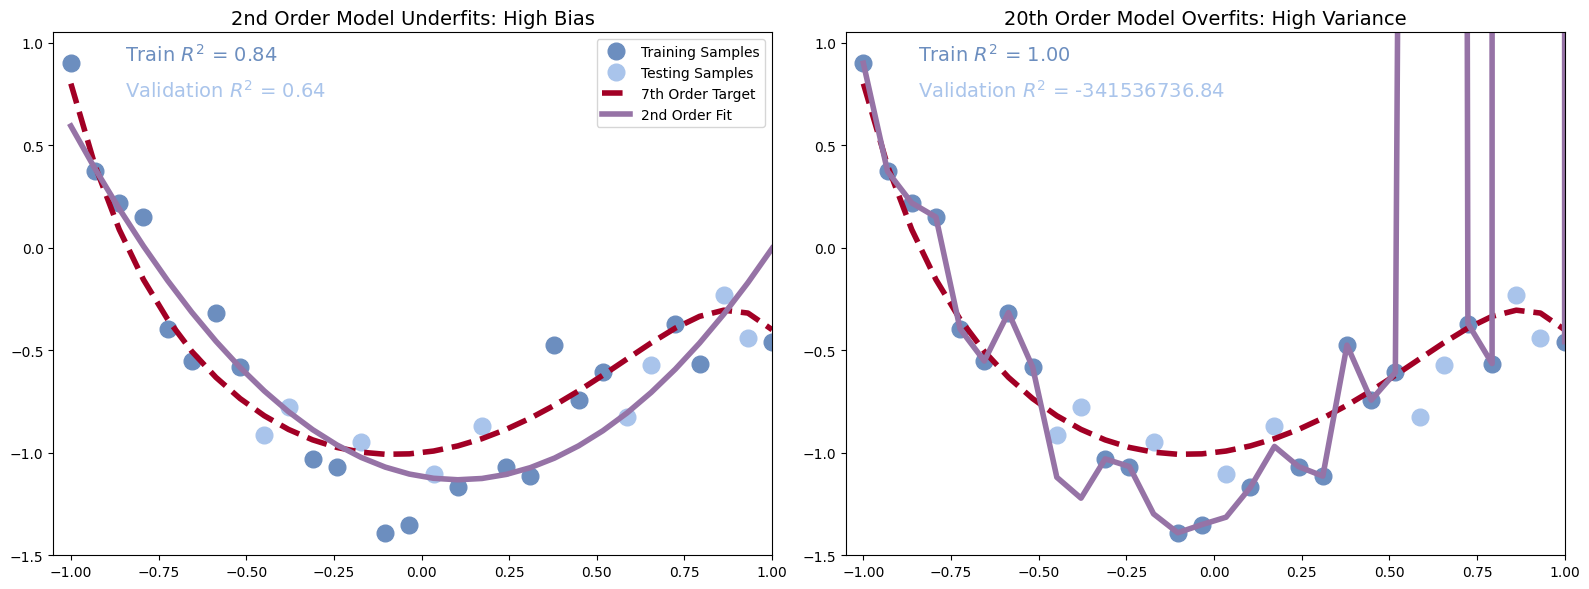

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].plot(X_train[order_train], y_train[order_train], "o", color='#6C8EBF', label="Training Samples", markersize=12)
ax[0].plot(X_test[order_test], y_test[order_test], "o", color='#A9C4EB', label="Testing Samples", markersize=12)
ax[0].text(0.1, 0.98, "Train $R^2$ = {0:.2f}".format(polynomial_fit_2.score(X_train.reshape(-1, 1), y_train)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='#6C8EBF')
ax[0].text(0.1, 0.91, "Validation $R^2$ = {0:.2f}".format(polynomial_fit_2.score(X_test.reshape(-1, 1), y_test)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='#A9C4EB')

ax[0].plot(X_target, y_target, linestyle="dashed", label="7th Order Target", linewidth=4)
ax[0].plot(X_target, polynomial_fit_2.predict(X_target.reshape(-1, 1)), label="2nd Order Fit", color="#9673A6", linewidth=4)
ax[0].legend(loc="upper right")
ax[0].axis([-1.05, 1.0, -1.5, 1.05])
ax[0].set_title("2nd Order Model Underfits: High Bias", size=14)

ax[1].plot(X_train[order_train], y_train[order_train], "o", color='#6C8EBF', label="Training Samples", markersize=12)
ax[1].plot(X_test[order_test], y_test[order_test], "o", color='#A9C4EB', label="Testing Samples", markersize=12)
ax[1].text(0.1, 0.98, "Train $R^2$ = {0:.2f}".format(polynomial_fit_20.score(X_train.reshape(-1, 1), y_train)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='#6C8EBF')
ax[1].text(0.1, 0.91, "Validation $R^2$ = {0:.2f}".format(polynomial_fit_20.score(X_test.reshape(-1, 1), y_test)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='#A9C4EB')

ax[1].plot(X_target, y_target, linestyle="dashed", label="7th Order Target", linewidth=4)
ax[1].plot(X_target, polynomial_fit_20.predict(X_target.reshape(-1, 1)), label="10th Order Fit", color="#9673A6", linewidth=4)

ax[1].axis([-1.05, 1.0, -1.5, 1.05])
ax[1].set_title("20th Order Model Overfits: High Variance", size=14)

fig.tight_layout()
fig.savefig('figures/ch04/bias_variance_tradeoff.png', bbox_inches='tight', dpi=600)
fig.savefig('figures/ch04/bias_variance_tradeoff.pdf', bbox_inches='tight', dpi=600);

**Code for Figure 4.19. Impact of high bias or high variance on model's sensitivity to trianing data**

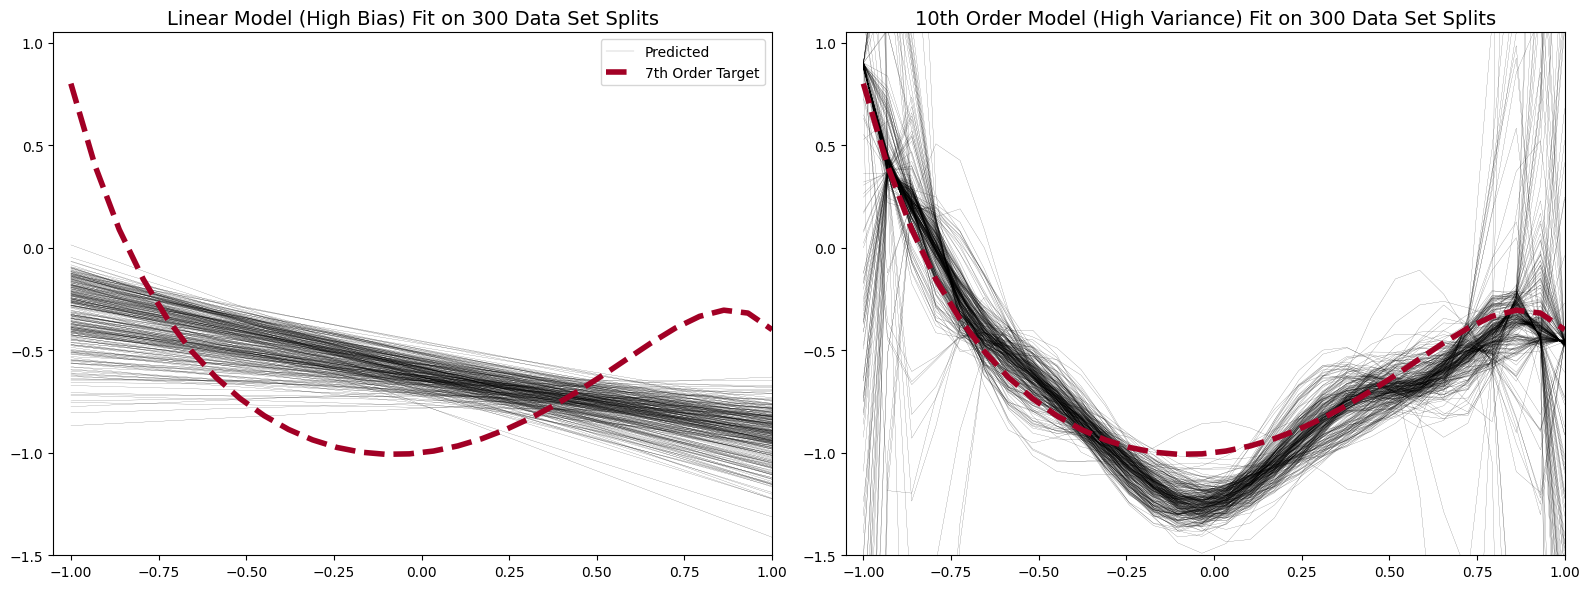

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i in range(300):
  X_train, X_test, y_train, y_test = train_test_split(
      X_target, y_sample, test_size=0.3, random_state=i,
  )

  linear_fit = make_pipeline(
    LinearRegression(),
  ).fit(X_train.reshape(-1, 1), y_train)

  polynomial_fit_10 = make_pipeline(
    PolynomialFeatures(degree=10),
    LinearRegression(),
  ).fit(X_train.reshape(-1, 1), y_train)

  if i == 0:
    ax[0].plot(X_target, linear_fit.predict(X_target.reshape(-1, 1)), label="Predicted", color="black", linewidth=0.1)
    ax[1].plot(X_target, polynomial_fit_10.predict(X_target.reshape(-1, 1)), label="Predicted", color="black", linewidth=0.1)
  else:
    ax[0].plot(X_target, linear_fit.predict(X_target.reshape(-1, 1)), color="black", linewidth=0.1)
    ax[1].plot(X_target, polynomial_fit_10.predict(X_target.reshape(-1, 1)), color="black", linewidth=0.1)

ax[0].plot(X_target, y_target, linestyle="dashed", label="7th Order Target", linewidth=4)
ax[1].plot(X_target, y_target, linestyle="dashed", label="7th Order Target", linewidth=4)
ax[0].legend(loc="upper right")

ax[0].axis([-1.05, 1.0, -1.5, 1.05])
ax[1].axis([-1.05, 1.0, -1.5, 1.05])

ax[0].set_title("Linear Model (High Bias) Fit on 300 Data Set Splits", size=14)
ax[1].set_title("10th Order Model (High Variance) Fit on 300 Data Set Splits", size=14)

fig.tight_layout()
fig.savefig('figures/ch04/bias_variance_definition.png', bbox_inches='tight', dpi=600)
fig.savefig('figures/ch04/bias_variance_definition.pdf', bbox_inches='tight', dpi=600);

### <b> <font color='#A20025'> Validation Curves & Learning Curves

Let's visualize validation curves and learning curves to better understand model performance as a function of hyperparameters and training data size.

**Code for Figure 4.21. Validation curves of several SGDRegressor hyperparameters**

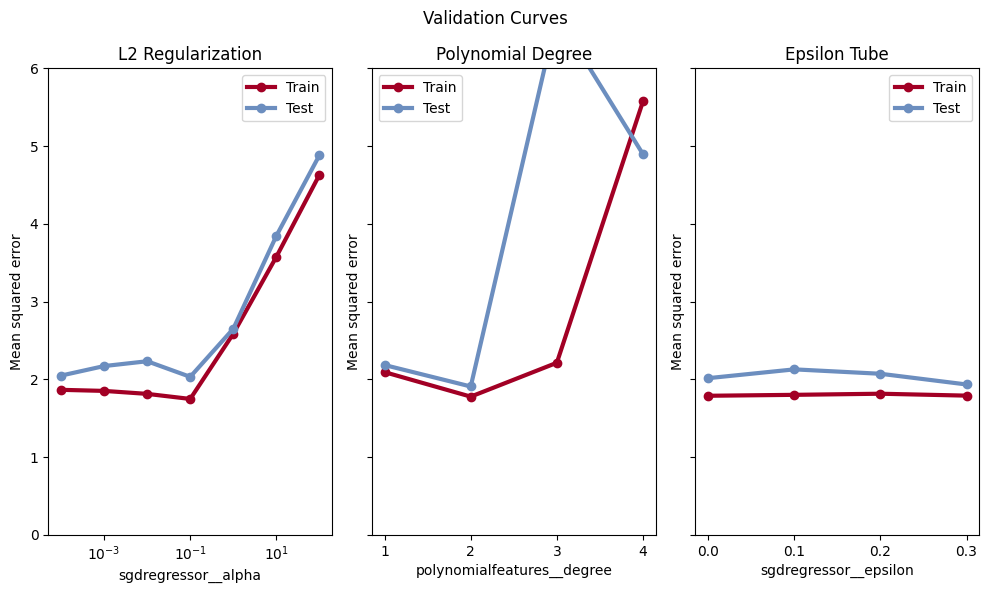

In [ ]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit, ValidationCurveDisplay

sgd_regressor = make_pipeline(
  SimpleImputer(strategy="median"),
  PolynomialFeatures(degree=2),
  StandardScaler(),
  SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='invscaling', loss="epsilon_insensitive", penalty='l2'),
)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharey=True)
fig.suptitle("Validation Curves")
ax[0].set_ylim(top=6)
common_params = {"estimator": sgd_regressor, "X": X_train, "y": y_train, "scoring": "neg_mean_squared_error", "std_display_style": None, "line_kw": {"marker": "o", "lw": 3}, "negate_score": True}

ValidationCurveDisplay.from_estimator(
  **common_params, param_name='sgdregressor__alpha', param_range=np.logspace(-4, 2, num=7), ax=ax[0],
)
handles, label = ax[0].get_legend_handles_labels()
#ax[0].legend(handles[:2], ["Training Score", "Validation Score"])
ax[0].set_title(f"L2 Regularization")

ValidationCurveDisplay.from_estimator(
  **common_params, param_name='polynomialfeatures__degree', param_range=np.arange(1, 5), ax=ax[1],
)
#ax[1].legend(handles[:2], ["Training Score", "Validation Score"])
ax[1].set_title(f"Polynomial Degree")

ValidationCurveDisplay.from_estimator(
  **common_params, param_name='sgdregressor__epsilon', param_range=[0, 0.1, 0.2, 0.3], ax=ax[2],
)
#ax[2].legend(handles[:2], ["Training Score", "Validation Score"])
ax[2].set_title(f"Epsilon Tube")
fig.tight_layout()
plt.savefig("figures/ch04/sgd_validation_curves.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch04/sgd_validation_curves.png", bbox_inches='tight', dpi=600)

**Code for Figure 4.20. Learning curves of RANSACRegressor vs SGDRegressor (SVR variant)**

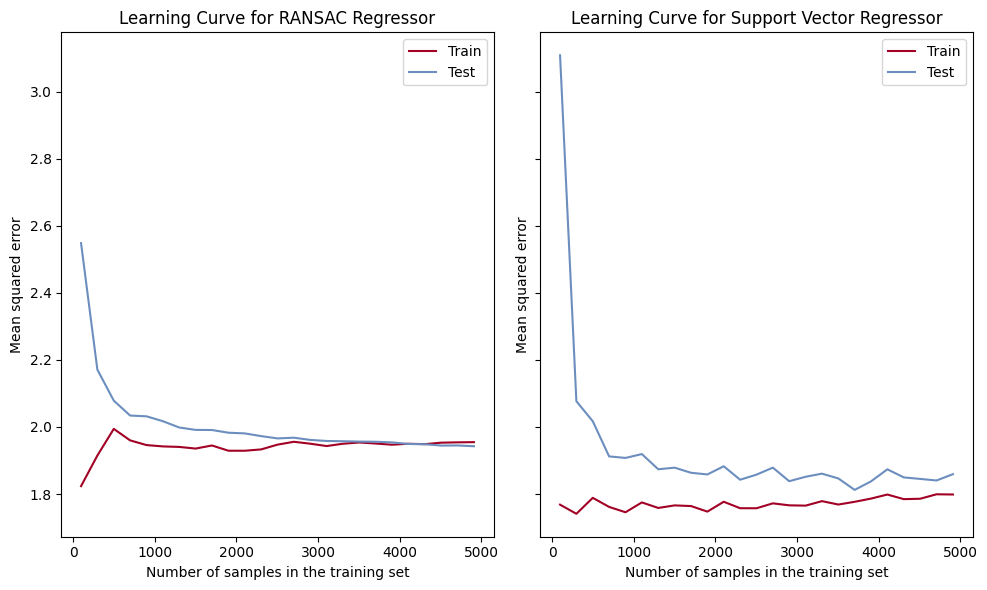

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.02, 1.0, 50),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "scoring": "neg_mean_squared_error",
    "score_type": "both",
    "std_display_style": None,
    "negate_score": True
}

estimator_names = {0 : 'RANSAC Regressor', 1 : 'Support Vector Regressor'}

for ax_idx, estimator in enumerate([ransac_regressor, sgd_regressor]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Train", "Test"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator_names[ax_idx]}")

fig.tight_layout()
plt.savefig("figures/ch04/learning_curves.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch04/learning_curves.png", bbox_inches='tight', dpi=600)

## <b> <font color='#A20025'> Summary

In this notebook, we've explored aqueous solubility prediction using various linear models:
 
1. **Data Preparation**:
   - Loaded and preprocessed solubility data from the AqSolDB dataset
   - Calculated molecular descriptors as features
   - Explored relationships between descriptors and solubility
 
2. **Model Development**:
   - Built a simple linear regression model as a baseline
   - Implemented Ridge regression with regularization
   - Used RANSAC for robust regression in the presence of outliers
   - Applied Support Vector Regression with SGD for flexibility
 
3. **Model Evaluation**:
   - Compared models using RMSE, MAE, and R²
   - Evaluated final model on the test set
   - Compared against ESOL as a benchmark
   - Performed y-scrambling to validate model significance
 
4. **Bias-Variance Analysis**:
   - Demonstrated the bias-variance tradeoff with polynomial regression
   - Visualized model sensitivity to training data
   - Examined validation and learning curves
 

## <b> <font color='#A20025'> Further Exploration

Here are some ideas for extending this work as you explore additional concepts in the text book:
 
1. **Try different molecular descriptors**:
   - Explore 3D descriptors that capture conformational information
   - Use topological indices that characterize molecular structure
 
2. **Apply more advanced models**:
   - Neural networks for capturing complex non-linear relationships
   - Ensemble methods like Random Forests or Gradient Boosting
 
3. **Investigate different solubility datasets**:
   - Compare predictions across different experimental conditions
   - Apply transfer learning from larger datasets
 
4. **Explore applicability domain analysis**:
   - Implement more sophisticated methods for defining the applicability domain
   - Investigate the relationship between prediction errors and distance from the training set

## <b> <font color='#A20025'> References

[1] Walters, P. Getting Real with Molecular Property Prediction. Practical Cheminformatics. https://practicalcheminformatics.blogspot.com/2023/06/getting-real-with-molecular-property.html


[2] Sorkun, M.C., Khetan, A. & Er, S. (2019). AqSolDB, a curated reference set of aqueous solubility and 2D descriptors for a diverse set of compounds. Sci. Data. https://doi.org/10.1038/s41597-019-0151-1
[3] Linear Models. Scikit-Learn. https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model


[4] Delaney, J.S. (2004). ESOL: Estimating Aqueous Solubility Directly from Molecular Structure. J. Chem. Info. Comp. Sci., 44 (3): 1000-1005. https://doi.org/10.1021/ci034243x

[5] Walters, P. Predicting Aqueous Solubility - It's Harder Than It Looks. Practical Cheminformatics. https://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html

[6] Lowe, D. (2012). Watch that Little Letter "c". In The Pipeline. https://www.science.org/content/blog-post/watch-little-letter-c

[7] Chuang, K.V., Keiser, M.J. (2018). Comment on “Predicting reaction performance in C–N cross-coupling using machine learning”. Science, 362. https://doi.org/10.1126/science.aat8603

[8] Abu-Mostafa, Y.S., Magdon-Ismail, M., Lin, H.T. Learning From Data. https://amlbook.com/

[9] Strategies to scale computationally: bigger data. Scikit-Learn. https://scikit-learn.org/stable/computing/scaling_strategies.html
